### Scroll all the way to the bootom to "FOLLOW INSTRUCTIONS BELOW"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import datetime
import json
import ipywidgets as widgets
from IPython.display import display

### Offer Goal History Data Import

In [ ]:
USE DATABASE KASHKICK;
USE SCHEMA KK_MYSQL;

In [450]:
SELECT *
FROM KK_OFFERGOALSHISTORY
WHERE OfferID='KFQDotsJLaLq'
ORDER BY created_at asc;

In [ ]:
df_db=cell5.to_pandas()

In [451]:
df_db.at[0, 'OLDDATA'] = df_db.at[0, 'NEWDATA']

In [452]:
### create DataOld
data_old=[]
for row in range (0,len(df_db)):
    data_old.append(df_db.loc[row,"OLDDATA"])
    

### Create DataNew
data_new=[]
for row in range (0,len(df_db)):
    data_new.append(df_db.loc[row,"NEWDATA"])

#### Create Date Values
dates=df_db["CREATED_AT"].reset_index().drop("index",axis=1)
dates=dates["CREATED_AT"].to_list()

### Functions

In [454]:
def TotalPotentialEarning(df):
    payout_list=[]
    for elem in range (0,len(df)):
        subset=json.loads(df[elem])
        payout=0
        for index in range (0,len(subset)):
            for key,value in subset[index].items():
                if key=="Payout":
                    payout=payout+float(value)
        payout_list.append(payout)

    return payout_list

In [455]:
def NumPayableEvents(df):
    L=[]
    for elem in range (0,len(df)):
        subset=json.loads(df[elem])
        num=0
        for index in range (0,len(subset)):
            for key,value in subset[index].items():
                if key=="Payout" and float(value)>0 :
                    num=num+1
        L.append(num)
    
    return L
    

In [456]:
def DaysToCompleteFullGame(df):
    L=[]
    for elem in range (0,len(df)):
        subset=json.loads(df[elem])
        days=0
        for index in range (0,len(subset)):
            for key,value in subset[index].items():
                if key=="DaysToComplete" and value is not None:
                    days=days+float(value)
        L.append(days)

    return L

In [457]:
def DaysToCompleteFirstGoal(df):
    L=[]
    for elem in range (0,len(df)):
        subset=json.loads(df[elem])
        days=0
        for index in range (0,len(subset)):
            for key,value in subset[index].items():
                if key=="Position" and value==2:
                    days=subset[index]["DaysToComplete"]
        L.append(days)

    return L

Total Potential Earning

In [462]:
old_payout_list=TotalPotentialEarning(data_old)
new_payout_list=TotalPotentialEarning(data_new)

#### Days to Complete First Goal

In [472]:
days_complete_first_old=DaysToCompleteFirstGoal(data_old)
for elem in range (0,len(days_complete_first_old)):
    if elem==0:
        pass
    else:
        if days_complete_first_old[elem] is None:
            days_complete_first_old[elem]=days_complete_first_old[elem-1]

In [473]:
days_complete_first_new=DaysToCompleteFirstGoal(data_new)
for elem in range (0,len(days_complete_first_new)):
    if elem==0:
        pass
    else:
        if days_complete_first_new[elem] is None:
            days_complete_first_new[elem]=days_complete_first_new[elem-1]

for i, elem in enumerate(days_complete_first_new):
    if isinstance(elem, str):
        days_complete_first_new[i] = int(elem)

## Modelling Daily

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Import Time Series Data

In [361]:
SELECT mt.year, 
       mt.week, 
       mt.day,
       mt.total_paid_us, 
       tl.total_liab,
       fg.total_first_goals_reached,
       tp.num_iap,
       tu.total_users
FROM (
    SELECT YEAR(e.DateTime) AS year, 
           WEEKISO(e.DateTime) AS week,
           DAYOFWEEKISO(e.DateTime) AS day,
           SUM(e.PaidUs) AS total_paid_us
    FROM (
        SELECT e.UserID,
               e.OfferID,
               e.PaidUs,
               e.DateTime
        FROM KK_EARNINGS e
        WHERE e.OfferID IN (
            SELECT OfferID 
            FROM (
                SELECT 
                    OfferID, 
                    MAX(offerable_id) AS filt 
                FROM KK_OFFERABLES
                GROUP BY OfferID
                HAVING (filt = 2 OR filt > 25) AND filt NOT IN (47, 48)
            ) AS ob
        )
        AND e.UserID IN (SELECT DISTINCT UserID FROM KK_EARNINGS WHERE OfferID = 'KFQDotsJLaLq') 
        AND e.UserID NOT IN (SELECT DISTINCT OldID FROM KK_SUBSCRIBERNOTE WHERE LOWER(Description) LIKE '%fraud%' AND OldID IS NOT NULL)
    ) e
    LEFT JOIN (
        SELECT UserID, MIN(DateTime) AS insttime
        FROM KK_EARNINGS
        WHERE OfferID = 'KFQDotsJLaLq'
        GROUP BY UserID
    ) inst 
    ON e.UserID = inst.UserID
    WHERE e.DateTime >= inst.insttime
    GROUP BY YEAR(e.DateTime), WEEKISO(e.DateTime), DAYOFWEEKISO(e.DateTime)
) mt
LEFT JOIN (
    SELECT YEAR(DateTime) AS year, 
           WEEKISO(DateTime) AS week,
           DAYOFWEEKISO(DateTime) AS day,
           COUNT(*) AS total_first_goals_reached
    FROM KK_EARNINGS
    WHERE OfferID = 'KFQDotsJLaLq' 
    AND Goal = 336
    GROUP BY YEAR(DateTime), WEEKISO(DateTime), DAYOFWEEKISO(DateTime)
) fg
ON mt.year = fg.year AND mt.week = fg.week AND mt.day = fg.day
LEFT JOIN (
    SELECT 
        YEAR(e.DateTime) AS year,
        WEEKISO(e.DateTime) AS week,
        DAYOFWEEKISO(e.DateTime) AS day,
        SUM(e.Amount) AS total_liab
    FROM KK_EARNINGS e
    WHERE e.OfferID = 'KFQDotsJLaLq'
    GROUP BY YEAR(e.DateTime), WEEKISO(e.DateTime), DAYOFWEEKISO(e.DateTime)
) tl
ON mt.year = tl.year AND mt.week = tl.week AND mt.day = tl.day
LEFT JOIN (
    SELECT 
        YEAR(e.DateTime) AS year,
        WEEKISO(e.DateTime) AS week,
        DAYOFWEEKISO(e.DateTime) AS day,
        SUM(CASE WHEN LOWER(og.Title) LIKE '%purchase%' THEN 1 ELSE 0 END) AS num_iap
    FROM KK_EARNINGS e
    LEFT JOIN KK_OFFERGOALS og ON e.OfferID = og.OfferID AND e.Goal = og.Goal
    WHERE e.OfferID = 'KFQDotsJLaLq'
    GROUP BY YEAR(e.DateTime), WEEKISO(e.DateTime), DAYOFWEEKISO(e.DateTime)
) tp
ON mt.year = tp.year AND mt.week = tp.week AND mt.day = tp.day
LEFT JOIN (
    SELECT YEAR(DateTime) AS year, 
           WEEKISO(DateTime) AS week, 
           DAYOFWEEKISO(DateTime) AS day,
           COUNT(DISTINCT UserID) AS total_users
    FROM KK_EARNINGS
    WHERE OfferID = 'KFQDotsJLaLq'
    GROUP BY YEAR(DateTime), WEEKISO(DateTime), DAYOFWEEKISO(DateTime)
) tu
ON mt.year = tu.year AND mt.week = tu.week AND mt.day = tu.day
ORDER BY mt.year, mt.week, mt.day;

In [363]:
df_rev1 = cell71.to_pandas()
df_rev1.columns=["year","week","day","total_paid_us","total_liab","total_first_goals_reached","num_iap","total_users"]

In [491]:
df_rev=df_rev1.copy(deep=True)

In [492]:
df_rev.tail()

,year,week,day,total_paid_us,total_liab,total_first_goals_reached,num_iap,total_users
443,2024,27,6,28115.8,950.0,69.0,66.0,1056
444,2024,27,7,34250.3,860.0,63.0,94.0,1209
445,2024,28,1,36545.6,1500.0,107.0,70.0,1427
446,2024,28,2,37860.5,1410.0,119.0,94.0,1535
447,2024,28,3,9247.1,320.0,23.0,17.0,328


### Dataframe creation

In [36]:
def CreateTimeSeriesDaily(l1:list,l2:list):
    df=pd.DataFrame({"Old":l1,
                "New":l2,
                "Date":dates})
    df["Date"]=pd.to_datetime(df["Date"])
    df["year"]=df["Date"].dt.isocalendar().year
    df["week"]=df["Date"].dt.isocalendar().week
    df["day"]=df["Date"].dt.isocalendar().day
    df1=df.groupby(["year","week","day"])["Date"].max().reset_index().merge(df,how="inner",on=["year","week","day","Date"])[["year","week","day","New"]]
    df1['prev_New'] = df1['New'].shift(1)

    # Filter the DataFrame to remove rows where the "New" value is the same as the previous row's "New" value
    df_filtered = df1[df1['New'] != df1['prev_New']]

    # Drop the 'prev_New' column as it is no longer needed
    df_filtered = df_filtered.drop(columns=['prev_New'])

    week_year_day_data= {
    'year': df_filtered["year"].to_list(),
    'week': df_filtered["week"].to_list(),
    'day':df_filtered["day"].to_list(),
    'New': df_filtered["New"].to_list()
    }
    week_year_day_data = pd.DataFrame(week_year_day_data)

    # Create a complete list of year-week combinations
    years = week_year_day_data['year'].unique()
    weeks = range(1, 52)
    days=range(0,6)

    all_combinations = pd.MultiIndex.from_product([years, weeks,days], names=['year', 'week','day'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()

    # Merge the complete list with the original DataFrame
    df_complete = pd.merge(all_combinations_df, week_year_day_data, on=['year', 'week','day'], how='left')

    # Fill missing values using forward fill followed by backfill
    df_complete['New'] = df_complete['New'].ffill().bfill()

    return df_complete

In [493]:
tpe_ts=CreateTimeSeriesDaily(old_payout_list,new_payout_list)
days_complete_first=CreateTimeSeriesDaily(days_complete_first_old,days_complete_first_new)
tpe_ts.rename(columns={"New":"total_potential_earning"},inplace=True)
days_complete_first.rename(columns={"New":"days_complete_first_goal"},inplace=True)

In [ ]:
df_rev

In [494]:
df_rev.fillna(0,inplace=True)
df_rev["total_liab"]=df_rev["total_liab"].astype(int)
df_rev["num_iap"]=df_rev["num_iap"].astype(int)
df_rev["total_paid_us"]=df_rev["total_paid_us"].astype(int)

In [495]:
df_rev=df_rev[:-1]

In [496]:
df_rev.rename(columns={"total_paid_us":"revenue"},inplace=True)

In [497]:
df=df_rev.merge(tpe_ts,on=["year","week","day"],how="inner").merge(days_complete_first,on=["year","week","day"],how="inner")
df=df[["year","week","day","revenue","total_liab","num_iap","total_users","total_potential_earning",\
"days_complete_first_goal","total_first_goals_reached"]]

In [498]:
df['tpe_dummy'] = (df['total_potential_earning'] != df['total_potential_earning'].shift()).astype(int)
df['dcfg_dummy'] = (df['days_complete_first_goal'] != df['days_complete_first_goal'].shift()).astype(int)
df["num_iap"]=df["num_iap"].diff(1)

In [499]:
df=df.dropna()

In [ ]:
df.tail(15)

In [ ]:
df=df[:-3]

### Exploratory Data Analysis

In [392]:
columns_to_plot = [
    "revenue","total_liab", "num_iap",
    "total_potential_earning",
 "days_complete_first_goal","total_first_goals_reached"
]

# Iterate through the specified columns and perform the Dickey-Fuller test
for column in columns_to_plot:
    result = adfuller(df[column])
    p_value = result[1]
    print(f"{column}: p-value = {p_value}")

revenue: p-value = 0.06646002269758444
total_liab: p-value = 0.0014983872225268046
num_iap: p-value = 3.573073442779053e-09
total_potential_earning: p-value = 0.2682208484621612
num_payable_events: p-value = 0.8000836333793164
days_complete_full_game: p-value = 0.229213595598104
days_complete_first_goal: p-value = 0.21102109256199114
total_first_goals_reached: p-value = 2.3140499565942742e-08


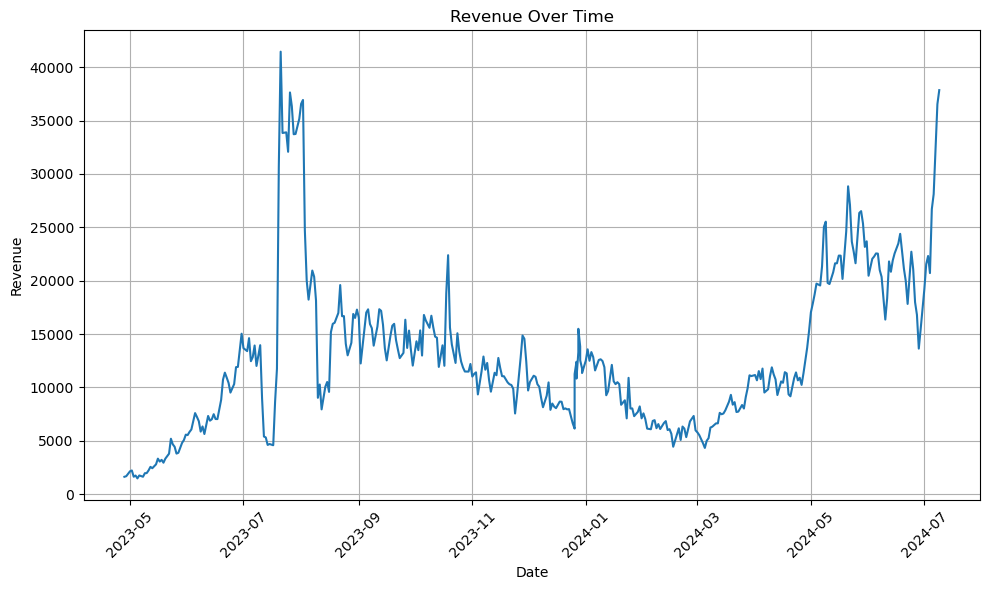

In [488]:
df['date'] = pd.to_datetime(df['year'].astype(str) + df['week'].astype(str) + df['day'].astype(str), format='%G%V%u')

# Sort by date to ensure proper ordering
df = df.sort_values('date')

# Plotting the revenue data
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['revenue'])
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
import pmdarima

In [ ]:
arima_model = auto_arima(df['revenue'], seasonal=False)  # Example with monthly seasonality

# Print the summary of the best model
print(arima_model.summary())

In [372]:
# Fit SARIMAX model with exogenous variables
order = (1,0,1)  # ARMA(1,1) orders: p, d, q
model = sm.tsa.SARIMAX(df['revenue'],exog=(df[["num_iap","total_first_goals_reached","dcfg_dummy","tpe_dummy"]]),order=order)
results = model.fit()

# predict
df["pred"]=results.predict()

# Print model summary,df
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  381
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3502.894
Date:                Tue, 16 Jul 2024   AIC                           7019.787
Time:                        14:57:27   BIC                           7047.387
Sample:                             0   HQIC                          7030.738
                                - 381                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
num_iap                      18.2164      3.638      5.008      0.000      11.087      25.346
total_first_goals_reached    -6.1312      3.081     -1.990      0.047     -12.171     

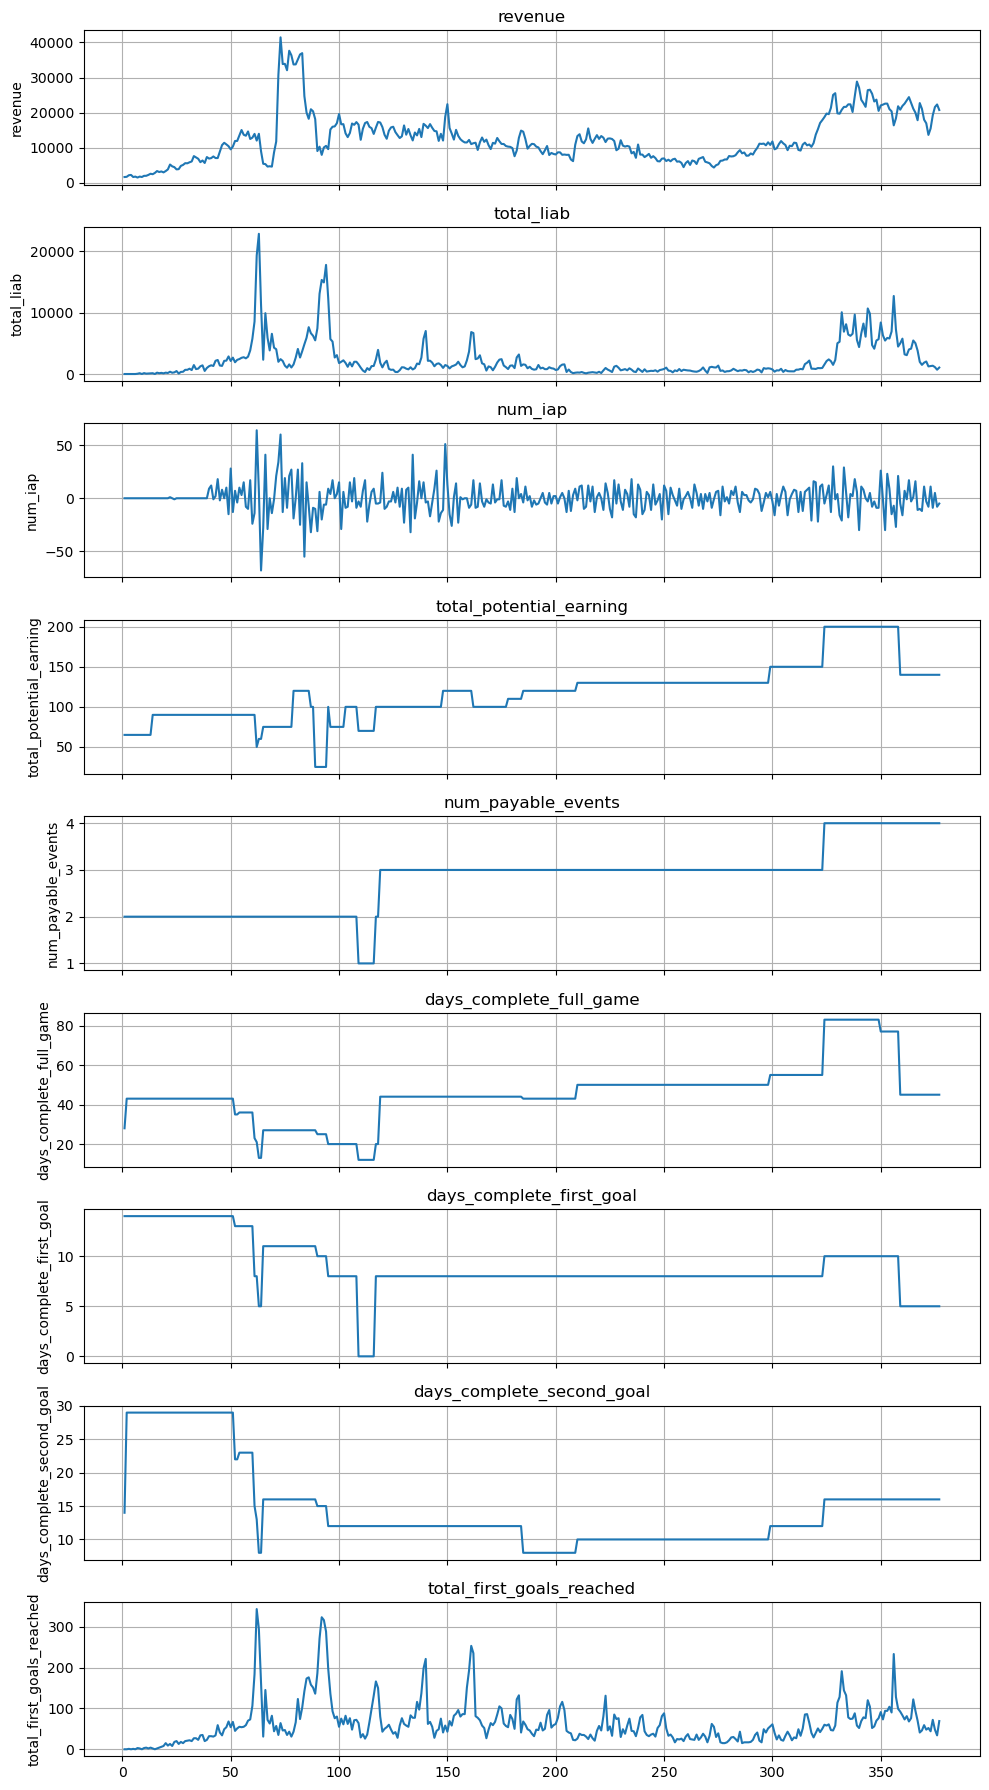

In [50]:
columns_to_plot = [
    "revenue","total_liab","num_iap",
    "total_potential_earning",
 "days_complete_first_goal","total_first_goals_reached"
]

# Number of subplots
num_plots = len(columns_to_plot)

# Create subplots
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots), sharex=True)

# Plot each time series in a separate subplot
for i, col in enumerate(columns_to_plot):
    df[col].plot(ax=axes[i], title=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [373]:
dfc=df[1:]

In [ ]:
dfc['date'] = pd.to_datetime(dfc['year'].astype(str) + dfc['week'].astype(str) + dfc['day'].astype(str), format='%G%V%u')

# Sort by date to ensure proper ordering
dfc = dfc.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dfc['date'], dfc['revenue'], linestyle='-', color='b', label='Revenue')
plt.plot(dfc['date'], dfc['pred'], linestyle='-', color='r', label='Prediction')
plt.title('Revenue vs Prediction Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

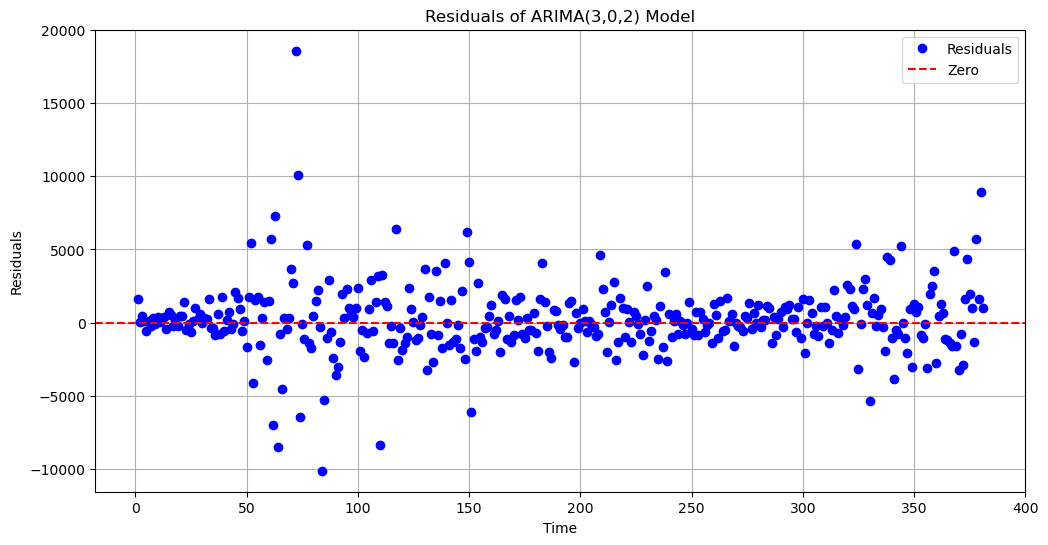

In [375]:
df['residuals'] = df['revenue'] - df['pred']

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(df['residuals'], marker='o', linestyle='None', color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Zero')
plt.title('Residuals of ARIMA(1,0,1) Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

plt.grid(True)
plt.show()

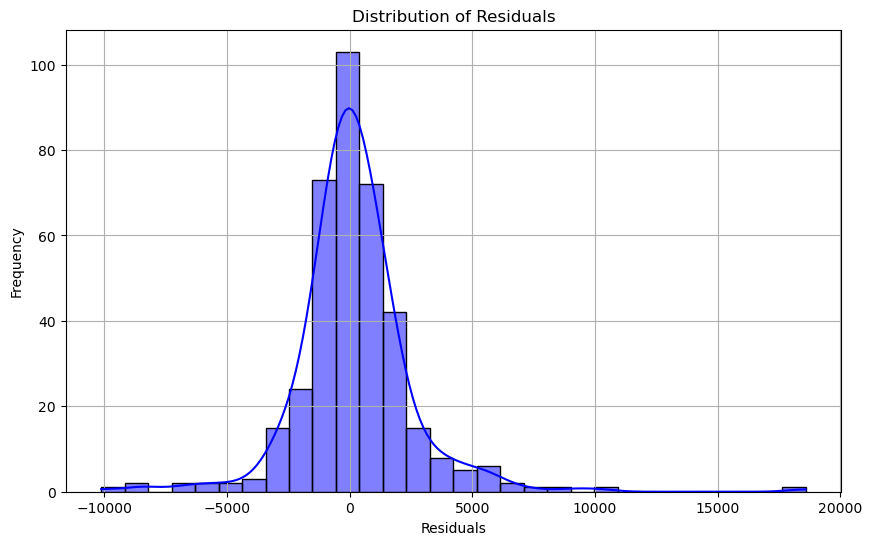

In [376]:
import seaborn as sns
residuals = df["revenue"]-df["pred"]

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [377]:
mae = mean_absolute_error(dfc["revenue"], dfc["pred"])

# Print RMSE
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1500.6203984197277


In [378]:
dw_stat = sm.stats.durbin_watson(df["revenue"]-df["pred"])
print(f'Durbin-Watson statistic: {dw_stat:.2f}')

Durbin-Watson statistic: 2.02


### Train/Test Evaluation

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
pd.set_option("display.max_rows",None)

#### Forecast Function

In [ ]:
def forecast(prop, interval):
    split_index = int(len(df) * prop)

    # Split the DataFrame
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]
    
    # Define the exogenous variables for training and test sets
    exog_train = df_train[["num_iap",  "tpe_dummy", "dcfg_dummy"]]
    exog_test = df_test[["num_iap",  "tpe_dummy", "dcfg_dummy"]]
    
    # Define the SARIMAX model
    order = (1, 1, 1)  # Example order, you may need to define the appropriate order
    model = sm.tsa.SARIMAX(df_train['revenue'], exog=exog_train, order=order)
    results = model.fit()
    
    # Iteratively make predictions for 3 days into the future
    predictions = []
    current_index = split_index
    
    for i in range(len(df_test) // interval):
        if current_index + interval > len(df):
            break
        
        # Define the exogenous variables for the current iteration
        exog_current = df.iloc[current_index:current_index+interval][["num_iap",  "tpe_dummy", "dcfg_dummy"]]
    
        # Make predictions
        forecast = results.get_forecast(steps=interval, exog=exog_current)
        pred = forecast.predicted_mean
        predictions.extend(pred)
    
        # Update the model with the new data
        df_train = df.iloc[:current_index+interval]
        exog_train = df_train[["num_iap", "tpe_dummy", "dcfg_dummy"]]
        model = sm.tsa.SARIMAX(df_train['revenue'], exog=exog_train, order=order)
   
        current_index += interval

        results = model.fit()
    
    pred_index = df.index[split_index:split_index+len(predictions)]
    pred_df = pd.DataFrame({'predicted_revenue': predictions}, index=pred_index)

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['revenue'], label='Actual Revenue')
    plt.plot(pred_df.index, pred_df['predicted_revenue'], label='Predicted Revenue', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title('Actual vs Predicted Revenue')
    plt.legend()
    plt.show()

    # Create a DataFrame with the actual and predicted values, along with the dummy variables
    result_df = pd.DataFrame({
        'actual_revenue': df_test['revenue'].iloc[:len(predictions)].values,
        'predicted_revenue': pred_df['predicted_revenue'].values,
        'tpe_dummy': df_test['tpe_dummy'].iloc[:len(predictions)].values,
        'dcfg_dummy': df_test['dcfg_dummy'].iloc[:len(predictions)].values,
        'num_iap': df_test['num_iap'].iloc[:len(predictions)].values
    })

    return result_df,pred_df

#### 3- Day Forward Iterative Forecast results

In [ ]:
df_result,pred_df=forecast(prop=0.6,interval=3)

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['revenue'], label='Actual Revenue')
plt.plot(pred_df.index, pred_df['predicted_revenue'], label='Predicted Revenue', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend()
plt.show()

In [446]:
res=res.dropna()
mae = mean_absolute_error(res["actual_revenue"], res["predicted_revenue"])
mae

2025.0824582596147

### Out of Sample Series Creation

In [ ]:
def OutSampleSeriesCreation(df,prop, interval,column,s:bool):
    split_index = int(len(df) * prop)

    # Split the DataFrame
    df_train = df.iloc[:split_index].copy()
    df_test = df.iloc[split_index:].copy()

    # Define the SARIMAX model
    arima_model = auto_arima(df[column], seasonal=s)# Example order, you may need to define the appropriate order
    order=arima_model.order
    model = sm.tsa.SARIMAX(df_train[column], order=order)
    results = model.fit()

    # Iteratively make predictions for `interval` days into the future
    predictions = []
    current_index = split_index

    # Make predictions
    forecast = results.predict(start=current_index, end=current_index + interval - 1)
    predictions.extend(forecast)

    return predictions

### OutSample not iterative

In [600]:
def OutSample(df, prop, interval, dcfg, tpe):
    split_index = int(len(df) * prop)

    # Split the DataFrame
    df_train = df.iloc[:split_index].copy()
    df_test = df.iloc[split_index:].copy()

    df1 = pd.DataFrame({
        "dcfg_dummy": [dcfg] * interval,
        "tpe_dummy": [tpe] * interval
    })
    
    #df1["tfgr_pred"] = OutSampleSeriesCreation(df, prop, interval, "total_first_goals_reached", True)
    df1["num_iap_pred"] = OutSampleSeriesCreation(df, prop, interval, "num_iap", False)

    # Define the exogenous variables for training and test sets
    exog_train = df_train[["num_iap", "tpe_dummy", "dcfg_dummy"]]
    
    # Define the SARIMAX model
    order = (1, 0, 1)  # Example order, you may need to define the appropriate order
    model = sm.tsa.SARIMAX(df_train['revenue'], exog=exog_train, order=order)
    results = model.fit()

    print(results.summary())

    df_train["pred"] = results.predict()
    
    if tpe == df["total_potential_earning"].iloc[-1] or tpe > df["total_potential_earning"].iloc[-1]:
        results.params[1] = results.params[1] / abs(round(df_train["total_potential_earning"].median() - 65))
    else:
        results.params[1] = results.params[1] / abs(round(df_train["total_potential_earning"].median() - 65))
        results.params[1] = -(results.params[1])

    if dcfg == df["days_complete_first_goal"].iloc[-1] or dcfg < df["days_complete_first_goal"].iloc[-1]:
        results.params[2] = results.params[2] / abs(round(df_train["days_complete_first_goal"].median() - 14))
    else:
        results.params[2] = results.params[2] / abs(round(df_train["days_complete_first_goal"].median() - 14))
        results.params[2] = -(results.params[2])



    print(results.params[1])
    print(results.params[2])
    
    # Define the exogenous variables for the current iteration
    exog_current = df1[["num_iap_pred", "tpe_dummy", "dcfg_dummy"]]

    # Make predictions for the next period
    forecast = results.get_forecast(steps=interval, exog=exog_current)
    pred = forecast.predicted_mean.tolist()
    conf_int = forecast.conf_int().values.tolist()

    lower_ci=[]
    upper_ci=[]

    for l in conf_int:
        lower_ci.append(l[0])

    for l in conf_int:
        upper_ci.append(l[1])
        

    # Create the DataFrame
    pred_df = pd.DataFrame({
        'predicted_revenue': pred,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci
    })

    return pred_df

### FOLLOW INSTRUCTIONS BELOW

In [ ]:
# Click on 3 dots in the top right of this code chunk and click "Run all above"

1. In the above cell click on 3 dots and click "Run All Above"

2. Below input the value for days to complete first goal next to equals sign
3. Below input the value for total potential earnings next to equals sing
4. Below input the value for interval (how many days into the future you want to predict). Note: The further you go into the future the less reliable the pridctions. Suggested 3-5 days
5. Run that cell and run the cell below using Ctrl+Enter

In [ ]:
# Option 1
days_to_complete_first_goal_option_1=5
total_potential_earnings_option_1=200
interval_option_1=5

# Option 2

days_to_complete_first_goal_option_2=5
total_potential_earnings_option_2=140
interval_option_2=5

In [ ]:
df

In [ ]:
df.tail()

In [ ]:
df_a=OutSample(df,1,interval_option_1,days_to_complete_first_goal_option_1,total_potential_earnings_option_1)
df_b=OutSample(df,1,interval_option_2,days_to_complete_first_goal_option_2,total_potential_earnings_option_2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot DataFrame A on the first subplot
ax1.plot(df_a.index, df_a['predicted_revenue'], label='Predicted Revenue Option A', marker='o')
ax1.plot(df_a.index, df_a['lower_ci'], label='Lower CI A', linestyle='--', marker='o')
ax1.plot(df_a.index, df_a['upper_ci'], label='Upper CI A', linestyle='--', marker='o')

# Add number labels above each dot for DataFrame A
for x, y in zip(df_a.index, df_a['predicted_revenue']):
    ax1.text(x, y + 1, f'${y:.2f}', ha='center', va='bottom', fontsize=13, color='black')
for x, y in zip(df_a.index, df_a['lower_ci']):
    ax1.text(x, y + 1, f'${y:.2f}', ha='center', va='bottom', fontsize=13, color='black')
for x, y in zip(df_a.index, df_a['upper_ci']):
    ax1.text(x, y + 1, f'${y:.2f}', ha='center', va='bottom', fontsize=13, color='black')

# Customize the first subplot
ax1.set_title('Revenue Predictions and Confidence Intervals - Option A')
ax1.set_xlabel('Index')
ax1.set_ylabel('Revenue ($)')
ax1.legend()
ax1.grid(True)

# Plot DataFrame B on the second subplot
ax2.plot(df_b.index, df_b['predicted_revenue'], label='Predicted Revenue Option B', marker='s')
ax2.plot(df_b.index, df_b['lower_ci'], label='Lower CI B', linestyle='--', marker='s')
ax2.plot(df_b.index, df_b['upper_ci'], label='Upper CI B', linestyle='--', marker='s')

# Add number labels above each dot for DataFrame B
for x, y in zip(df_b.index, df_b['predicted_revenue']):
    ax2.text(x, y + 1, f'${y:.2f}', ha='center', va='bottom', fontsize=13, color='black')
for x, y in zip(df_b.index, df_b['lower_ci']):
    ax2.text(x, y + 1, f'${y:.2f}', ha='center', va='bottom', fontsize=13, color='black')
for x, y in zip(df_b.index, df_b['upper_ci']):
    ax2.text(x, y + 1, f'${y:.2f}', ha='center', va='bottom', fontsize=13, color='black')

# Customize the second subplot
ax2.set_title('Revenue Predictions and Confidence Intervals - Option B')
ax2.set_xlabel('Index')
ax2.set_ylabel('Revenue ($)')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print("Option A")
df_a

print("Option B")
df_b